# Day 15

In [1]:
%cd ..

from inspect import cleandoc
from matplotlib import pyplot
import ipytest
ipytest.autoconfig()

/home/vagrant/Development/advent-of-code-2022/python


In [2]:
from aocd import get_data
data = get_data(year=2022, day=15)

In [3]:
example = cleandoc("""
    Sensor at x=2, y=18: closest beacon is at x=-2, y=15
    Sensor at x=9, y=16: closest beacon is at x=10, y=16
    Sensor at x=13, y=2: closest beacon is at x=15, y=3
    Sensor at x=12, y=14: closest beacon is at x=10, y=16
    Sensor at x=10, y=20: closest beacon is at x=10, y=16
    Sensor at x=14, y=17: closest beacon is at x=10, y=16
    Sensor at x=8, y=7: closest beacon is at x=2, y=10
    Sensor at x=2, y=0: closest beacon is at x=2, y=10
    Sensor at x=0, y=11: closest beacon is at x=2, y=10
    Sensor at x=20, y=14: closest beacon is at x=25, y=17
    Sensor at x=17, y=20: closest beacon is at x=21, y=22
    Sensor at x=16, y=7: closest beacon is at x=15, y=3
    Sensor at x=14, y=3: closest beacon is at x=15, y=3
    Sensor at x=20, y=1: closest beacon is at x=15, y=3
    """)

In [90]:
from dataclasses import dataclass, field
from functools import cached_property, reduce
from operator import or_
import re
from typing import ClassVar, Self
from aoc22.geometry import Point, Rectangle

@dataclass(frozen=True)
class Interval:
    lo: int
    hi: int
    
    def __and__(self, other: Self) -> Self|None:
        if self.lo <= other.hi and other.lo <= self.hi:
            return Interval(max(self.lo, other.lo), min(self.hi, other.hi))
        else:
            return None
    
    def __contains__(self, item: int) -> bool:
        return self.lo <= item <= self.hi

@dataclass(frozen=True)
class Sensor:
    position: Point
    closest_beacon: Point
    
    SENSOR_RE: ClassVar = re.compile("Sensor at x=(-?\d+), y=(-?\d+): closest beacon is at x=(-?\d+), y=(-?\d+)")

    @classmethod
    def parse(cls, text: str) -> Self:
        m = cls.SENSOR_RE.fullmatch(text)
        return cls(Point(int(m.group(1)), int(m.group(2))), Point(int(m.group(3)), int(m.group(4))))
    
    @cached_property
    def radius(self):
        return (self.position - self.closest_beacon).norm()
    
    def covered_interval(self, y: int) -> Interval|None:
        dy = abs(self.position.y - y)
        
        if dy > self.radius:
            return None
        else:
            dx = self.radius - dy
            return Interval(self.position.x - dx, self.position.x + dx)
            
    
    def __contains__(self, p: Point) -> bool:
        return (self.position - p).norm() <= self.radius

@dataclass
class ManhattanCircle:
    center: Point
    radius: int
    
    def points(self):
        return (
            self.center + (dx, s * (self.radius - abs(dx)))
            for s, t in [(-1, 0), (1, 1)]
            for dx in range(-self.radius + t, self.radius + t)
        )
    
@dataclass(frozen=True)
class SensorScan:
    sensors: list[Sensor] = field(default_factory=list)
    
    @classmethod
    def parse(cls, text: str) -> Self:
        return cls([
            Sensor.parse(line)
            for line in text.splitlines()
        ])
    
    def absent_beacon_position_count(self, y: int) -> int:
        bounds = self.bounds
        sensors = {
            sensor
            for sensor in self.sensors
            if abs(sensor.position.y - y) <= sensor.radius
        }
        beacons = {
            sensor.closest_beacon.x
            for sensor in sensors
            if sensor.closest_beacon.y == y
        }
        covered_intervals = [sensor.covered_interval(y) for sensor in sensors]
        return sum(
            x not in beacons and any(x in interval for interval in covered_intervals)
            for x in range(self.bounds.lo.x, self.bounds.hi.x + 1)
        )
    
    def find_distress_signal(self, bounds: Rectangle) -> Point:
        for sensor in self.sensors:
            for p in ManhattanCircle(sensor.position, sensor.radius + 1).points():
                if p in bounds and all(p not in other_sensor for other_sensor in self.sensors):
                    return p
    
    @cached_property
    def bounds(self) -> Rectangle:
        lo = Point(
            min(sensor.position.x - sensor.radius for sensor in self.sensors),
            min(sensor.position.y - sensor.radius for sensor in self.sensors),
        )
        hi = Point(
            max(sensor.position.x + sensor.radius for sensor in self.sensors),
            max(sensor.position.y + sensor.radius for sensor in self.sensors),
        )
        return Rectangle(lo, hi)
    
    def image(self):
        SENSOR = (0, 0, 255)
        BEACON = (255, 0, 0)
        IN_RANGE = (0, 0, 125)
        NOTHING = (0, 0, 0)
        
        sensors = {sensor.position for sensor in self.sensors}
        beacons = {sensor.closest_beacon for sensor in self.sensors}
        bounds = self.bounds
        return [
            [
                SENSOR if Point(x, y) in sensors
                else BEACON if Point(x, y) in beacons
                else IN_RANGE if any(Point(x, y) in sensor for sensor in self.sensors)
                else NOTHING
                #for x in range(bounds.lo.x, bounds.hi.x+1)
                for x in range(0, 20)
            ]
            #for y in range(bounds.lo.y, bounds.hi.y+1)
            for y in range(0, 20)
        ]

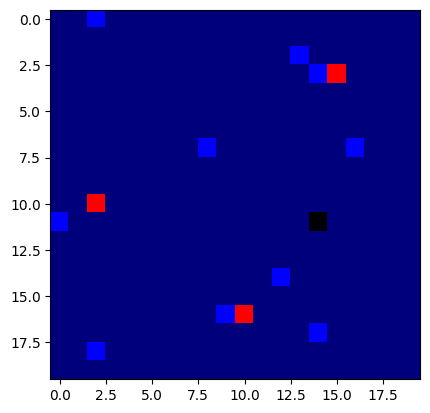

In [45]:
pyplot.imshow(SensorScan.parse(example).image())

In [91]:
%%ipytest

def test_absent_beacon_position_count():
    scan = SensorScan.parse(example)
    assert 26 == scan.absent_beacon_position_count(10)
    
def test_find_distress_signal():
    scan = SensorScan.parse(example)
    assert Point(14, 11) == scan.find_distress_signal(Rectangle(Point(0, 0), Point(20, 20)))

..                                                                                           [100%]
2 passed in 0.02s


In [92]:
data_scan = SensorScan.parse(data)

In [88]:
data_scan.absent_beacon_position_count(2_000_000)

5461729

In [97]:
x, y = data_scan.find_distress_signal(Rectangle(Point(0, 0), Point(4_000_000, 4_000_000)))
x * 4_000_000 + y

10621647166538